In [1]:
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, cross_val_predict, cross_validate

In [2]:
import timeit

def create_df():
    header = ['id', 'tweet', 'target']

    df = pd.read_csv('sentiment_tweets3.csv', names=header, header=0, encoding='latin-1')

    df = df.drop('id', axis=1)

    return df

timeit.Timer(create_df).timeit(number=1) * 1000

49.58509999999983

In [3]:
header = ['id', 'tweet', 'target']

tweet_df = pd.read_csv('sentiment_tweets3.csv', names=header, header=0, encoding='latin-1')
suicide_df = pd.read_csv('Suicide_Detection.csv', names=header, header=0, encoding='latin-1')
tweet_df = tweet_df.drop('id', axis=1)
suicide_df = suicide_df.drop('id', axis=1)
suicide_df['target'] = suicide_df['target'].map({'suicide': 1, 'non-suicide': 0})

df = pd.concat([tweet_df, suicide_df], ignore_index=True, sort=False)

df

,tweet,target
0,just had a real good moment. i missssssssss hi...,0
1,is reading manga http://plurk.com/p/mzp1e,0
2,@comeagainjen http://twitpic.com/2y2lx - http:...,0
3,@lapcat Need to send 'em to my accountant tomo...,0
4,ADD ME ON MYSPACE!!! myspace.com/LookThunder,0
...,...,...
242383,If you don't like rock then your not going to ...,0
242384,You how you can tell i have so many friends an...,0
242385,pee probably tastes like salty teaðð¦â¼ï...,0
242386,The usual stuff you find hereI'm not posting t...,1


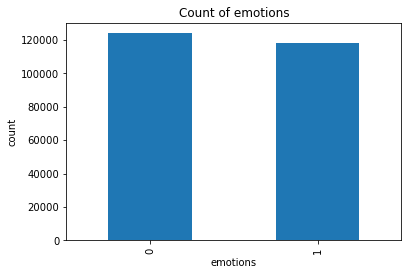

In [4]:
df['target'].value_counts().sort_index().plot(kind='bar', title='Count of emotions')
plt.xlabel("emotions")
plt.ylabel("count")

plt.show()

In [6]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem.porter import PorterStemmer

In [8]:
import string
import re
stopwords = set(nltk.corpus.stopwords.words('english'))

# token = [WordNetLemmatizer().lemmatize(w) for w in stopwords_removed_token]

def clean_words(words):
    table = str.maketrans('', '', string.punctuation)
    splitted_words = words.split()

    lower_split = [w for w in splitted_words if "@" not in w]
    lower_split = [w for w in lower_split if "#" not in w]
    lower_split = [w for w in lower_split if "http" not in w]
    
    lower_split = [w.strip() for w in lower_split]
    lower_split = [w for w in lower_split if not w.isdigit()]
    lower_split = [w for w in lower_split if w.isalpha()]

    lower_split = [w.translate(table) for w in lower_split]

    stopwords_removed_token = [w for w in lower_split if not w in stopwords]
    token = [PorterStemmer().stem(w) for w in stopwords_removed_token]

    token = " ".join(str(x) for x in token)
    return token

df['tweet'] = df['tweet'].apply(lambda x: clean_words(x))

df.head(10)

,tweet,target
0,real good missssssssss,0
1,read manga,0
2,,0
3,need send account i even refer those support,0
4,add me on,0
5,good time tonight though,0
6,someon alreadi fiber home mean least regular,0
7,possibl nice,0
8,nite twittervil workout,0
9,sweet dream,0


In [9]:
x_data = df['tweet']
y_data = df['target']

x_train, x_test, y_train, y_test = train_test_split(df['tweet'], df['target'], test_size=0.3, random_state=100, shuffle=True)


In [16]:
from xgboost import XGBClassifier
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt
# from sklearn.feature_extraction.text import TfidfVectorizer

In [18]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline


In [22]:
# Create the XGBoostClassifier
count_vect = CountVectorizer()
count_xgb_clf = Pipeline([
    ('count_vect', CountVectorizer()),
    ('clf', XGBClassifier())
])

In [20]:
cv_result = cross_validate(count_xgb_clf, x_train, y_train, scoring=['f1', 'recall', 'accuracy', 'precision'], cv=6, n_jobs=-1)
print(cv_result['test_f1'].mean())
print(cv_result['test_recall'].mean())
print(cv_result['test_accuracy'].mean())
print(cv_result['test_precision'].mean())

cv_result

0.8917650272573298
0.8627424995226814
0.8976902400498935
0.9228125913787938


{'fit_time': array([66.13013077, 67.50142908, 68.39637041, 67.21917844, 68.18260002,
        67.61360288]),
 'score_time': array([1.53257561, 1.29939079, 1.06650376, 1.24723864, 0.96869302,
        1.0556252 ]),
 'test_f1': array([0.89133446, 0.89197255, 0.89141745, 0.88893873, 0.89543292,
        0.89149406]),
 'test_recall': array([0.86181687, 0.86543612, 0.86196164, 0.86072101, 0.86506443,
        0.86145494]),
 'test_accuracy': array([0.89734432, 0.89759185, 0.89741504, 0.89493599, 0.90130137,
        0.89755287]),
 'test_precision': array([0.92294574, 0.92018779, 0.92295768, 0.91906934, 0.92801118,
        0.92370382])}

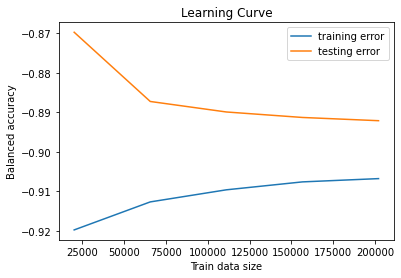

In [21]:
from sklearn.model_selection import learning_curve
import numpy as np

train_sizes, train_scores, test_scores, fit_times, score_times = learning_curve(estimator=count_xgb_clf, X=np.asarray(df['tweet']), y=np.asarray(df['target']), cv=6, scoring='balanced_accuracy', random_state=100, return_times=True, n_jobs=-1)
plt.plot(train_sizes, np.mean(-train_scores,axis=1), label='training error')
plt.plot(train_sizes, np.mean(-test_scores,axis=1), label='testing error')
plt.title("Learning Curve")
plt.xlabel("Train data size")
plt.ylabel("Balanced accuracy")
plt.legend()